In [1]:
import os
os.environ['autocnet_config'] = '/work/users/jmapel/autocnet/sample.yml'
os.environ['PROJ_LIB'] = '/home/jmapel/.conda/envs/autocnet/share/proj'

from ctypes.util import find_library
import ctypes


from ctypes.util import find_library
ctypes.CDLL(find_library('usgscsm'))

from autocnet.graph.network import NetworkCandidateGraph

/home/jmapel/.conda/envs/autocnet/lib/python3.6/site-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))


In [ ]:
# First run
import glob
ncg = NetworkCandidateGraph.from_filelist(glob.glob('/scratch/jmapel/ctx/autocnet/demo_images/*.cub'))

In [2]:
# On subsequent runs
ncg = NetworkCandidateGraph().from_database()

In [3]:
len(ncg)

13

/home/jmapel/.conda/envs/autocnet/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


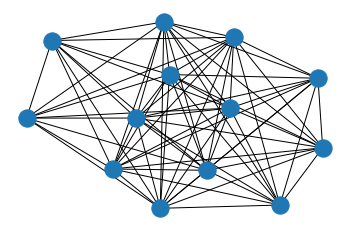

In [4]:
ncg.plot()  # Don't do this with ~3k nodes.

In [5]:
# Run the 2 sql commands in the sql directory of the autocnet repo to compute overlaps and get the overlap arrays populates

In [6]:
# This block is used to compute the overlapping polygon components and then place points into them.
from autocnet.spatial.overlap import place_points_in_overlaps

# Place points
place_points_in_overlaps(ncg, height=-3000) # This value is good for elysium, but needs to be more granularly parameterizable
# A bad height value results in very poor results... The height is height above (below) the sphere (the aeroid).
# To generalize this, we would spawn a new cluster job for each geomety and pull a height dynamically from from reference

In [7]:
# This block converts the points into matches
for s, d, e in ncg.edges(data='data'):  # intentionally in a loop so this doesn't spawn a cluster job
    e.network_to_matches()
    

In [8]:
type(ncg.edges)

networkx.classes.reportviews.EdgeView

In [9]:
import networkx as nx
isinstance(ncg.edges, nx.classes.reportviews.EdgeView)

True

In [14]:
# This block computes the fundamental matrices
# ncg.compute_fundamental_matrices(method='ransac', maskname='fundamental')
ncg.apply('compute_fundamental_matrix', method='ransac', maskname='fundamental')

72

In [11]:
# This block converts the points into matches
counters = []
for s, d, e in ncg.edges(data='data'):  # intentionally in a loop so this doesn't spawn a cluster job
    counters.append(e.mask_to_counter('fundamental'))

In [12]:
from collections import Counter
from autocnet import Session
from autocnet.io.db.model import Measures

aggregate = sum(counters, Counter())

# Now I need to take the output here and then look in qnet to see wtf is going on. Do we have a threshold here
# for blowing away bad stuff? If so, where? I should probably normalize all of these too based on the number of other
# images that they exist in. In other words, count/n-images
to_pop = []
session = Session()
for k, v in aggregate.items():
    pid = session.query(Measures).filter(Measures.id == k).first().pointid
    nimages = len(session.query(Measures).filter(Measures.pointid == pid).all())
    outlier_ratio = v / nimages  # This is the metric to test on (maybe?) - the ratio of the # of times the measure is 
                                  # flagged as bad to the number of measures associated with the point.
    # These are rules that are going to need testing / vetting. Are these appropriate values?
    if outlier_ratio <= 0.5 or (outlier_ratio <= 0.5 and nimages == 2):
        to_pop.append(k)
    else:
        aggregate[k] = v / len(session.query(Measures).filter(Measures.pointid == pid).all())
for k in to_pop:
    aggregate.pop(k)

In [13]:
session = Session()
make_inactive = list(aggregate.keys())
session.query(Measures).filter(Measures.id.in_(make_inactive)).update({'active':False}, synchronize_session='fetch')
session.commit()

In [18]:
ncg.to_isis('/scratch/jmapel/ctx/autocnet/demo.net')